## 필요한 라이브러리 불러오기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
#Tensorflow가 활용할 GPU가 장착되어 있는지 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. ResNet 구현

###### ResNet-34와 ResNet-50은 모두 conv block이라고 불리는 블록 구조를 각각 3, 4, 6, 3개씩 반복해서 쌓은 형태라는 공통점을 가지고 있음

###### ResNet-34의 경우 Block은 3x3 kernel인 Convolution layer로만 구성되어있지만, ResNet-50은 1x1 Convolution이 앞뒤로 붙어 더 많은 레이어를 한 블록 내에 가짐.

In [3]:
def build_resnet_block(input_layer,
                      num_cnn = 3,
                      channel = 64,
                      block_num = 1,
                      is_50 = False) :
    #입력 레이어
    x = input_layer
    
    #ResNet-34
    if is_50 is False :
        for cnn_num in range(num_cnn):

            if (cnn_num==0):
                if (block_num != 0):
                    x = keras.layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)
                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'stage_{block_num+2}_{cnn_num+1}_conv1'
                )(x)
                x = keras.layers.BatchNormalization(name=f"stage_{block_num+2}_bn{cnn_num+1}_1")(x)
                x = keras.layers.Activation('relu')(x)

                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'stage_{block_num+2}_{cnn_num+1}_conv2'
                )(x)
                shortcut = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'stage_{block_num+2}_{cnn_num+1}_conv2'
                )(input_layer)
                x = keras.layers.BatchNormalization(name=f"stage_{block_num+2}_bn{cnn_num+1}_2")(x)
                shortcut=keras.layers.BatchNormalization(name=f"stage_{block_num+2}_shortcut{cnn_num+1}_2")(x)
                x = keras.layers.Add()([x, shortcut])
                x = keras.layers.Activation(activation='relu')(x)

            else:
                shortcut=x
                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'stage_{block_num+2}_{cnn_num+1}_conv1'
                )(x)
                x = keras.layers.BatchNormalization(name=f"stage_{block_num+2}_bn{cnn_num+1}_1")(x)
                x = keras.layers.Activation('relu')(x)

                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'stage_{block_num+2}_{cnn_num+1}_conv2'
                )(x)
                x = keras.layers.BatchNormalization(name=f"stage_{block_num+2}_bn{cnn_num+1}_2")(x)
                x = keras.layers.Add()([x, shortcut])
                x = keras.layers.Activation('relu')(x)
                
    
    #ResNet-50
    else :
        for cnn_num in range(num_cnn):
        
            if (cnn_num==0):
                if (block_num != 0):
                    x = keras.layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)
                x = keras.layers.Conv2D(
                    filters=channel[0],
                    kernel_size=(1,1),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'stage_{block_num+2}_{cnn_num+1}_conv1'
                )(x)
                x = keras.layers.BatchNormalization(name=f"stage_{block_num+2}_bn{cnn_num+1}_1")(x)
                x = keras.layers.Activation('relu')(x)

                x = keras.layers.Conv2D(
                    filters=channel[1],
                    kernel_size=(3,3),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'stage_{block_num+2}_{cnn_num+1}_conv2'
                )(x)
                x = keras.layers.BatchNormalization(name=f"stage_{block_num+2}_bn{cnn_num+1}_2")(x)
                x = keras.layers.Activation('relu')(x)
                x = keras.layers.Conv2D(
                    filters=channel[2],
                    kernel_size=(3,3),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'stage_{block_num+2}_{cnn_num+1}_conv3'
                )(x)
                x = keras.layers.BatchNormalization(name=f"stage_{block_num+2}_bn{cnn_num+1}_3")(x)
                
                shortcut = keras.layers.Conv2D(
                    filters=channel[2],
                    kernel_size=(1,1),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'stage_{block_num+2}_{cnn_num+1}_conv3'
                )(input_layer)
                shortcut=keras.layers.BatchNormalization(name=f"stage_{block_num+2}_shortcut{cnn_num+1}_2")(x)
                
                x = keras.layers.Add()([x, shortcut])
                x = keras.layers.Activation(activation='relu')(x)

            else:
                shortcut=x
                x = keras.layers.Conv2D(
                    filters=channel[0],
                    kernel_size=(1,1),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'stage_{block_num+2}_{cnn_num+1}_conv1'
                )(x)
                x = keras.layers.BatchNormalization(name=f"stage_{block_num+2}_bn{cnn_num+1}_1")(x)
                x = keras.layers.Activation('relu')(x)

                x = keras.layers.Conv2D(
                    filters=channel[1],
                    kernel_size=(3,3),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'stage_{block_num+2}_{cnn_num+1}_conv2'
                )(x)
                x = keras.layers.BatchNormalization(name=f"stage_{block_num+2}_bn{cnn_num+1}_2")(x)
                x = keras.layers.Activation('relu')(x)
                x = keras.layers.Conv2D(
                    filters=channel[2],
                    kernel_size=(3,3),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'stage_{block_num+2}_{cnn_num+1}_conv3'
                )(x)
                x = keras.layers.BatchNormalization(name=f"stage_{block_num+2}_bn{cnn_num+1}_3")(x)
                x = keras.layers.Add()([x, shortcut])
                x = keras.layers.Activation(activation='relu')(x)
             
            
    return x

In [4]:
def build_resnet(input_shape = (32,32,3),
                num_cnn_list = [3,4,6,3],
                channel_list = [64, 128, 256, 512],
                num_classes = 10,
                is_50 = False,
                ) :
    
    #모델을 만들기 전에 config list들이 같은 길이인지 확인.
    assert len(num_cnn_list) == len(channel_list)
    
    #input layer 생성
    input_layer = keras.layers.Input(shape=input_shape)
    
    output = input_layer
    
    output = output
    output = keras.layers.Conv2D(64, (7,7), kernel_initializer='he_normal', padding='same', strides=2,name="stage1_conv")(output)
    output = keras.layers.BatchNormalization(name="stage1_batchnomalization")(output)
    output = keras.layers.Activation('relu')(output)
    
    if is_50:
        channel_list=[[64,64,256],[128,128,512],[256,256,1024],[512,512,2048]]
        
    #config list 길이만큼 반복해서 블록을 생성.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        if i ==0:
            output = keras.layers.MaxPooling2D((3, 3), strides=2, padding='same',name="stage2_0_maxpooling")(output)
        
        output = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i,
            is_50=is_50
        )
        
    output = keras.layers.AveragePooling2D(padding="same")(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(10, activation='relu', name='fc1000')(output)
    #output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    
    return model

## 1.2 ResNet-34

In [5]:
resnet_34 = build_resnet(input_shape=(32,32,3), is_50 = False)
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
stage1_conv (Conv2D)            (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
stage1_batchnomalization (Batch (None, 16, 16, 64)   256         stage1_conv[0][0]                
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           stage1_batchnomalization[0][0]   
______________________________________________________________________________________________

## 1.3 ResNet-50

In [6]:
resnet_50 = build_resnet(input_shape=(32,32,3), is_50 = True)
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
stage1_conv (Conv2D)            (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
stage1_batchnomalization (Batch (None, 16, 16, 64)   256         stage1_conv[0][0]                
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16, 16, 64)   0           stage1_batchnomalization[0][0]   
____________________________________________________________________________________________

## 2. Plain Network 만들기

In [7]:
#ResNet block에서 shortcut을 제외한 plain block 생성

def build_plainnet_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                    is_50=False
                   ):
    #입력 레이어
    x = input_layer
    
    #Plain-34
    if is_50 is False :
        for cnn_num in range(num_cnn):

            if (cnn_num==0):
                if (block_num != 0):
                    x = keras.layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)
                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'stage_{block_num+2}_{cnn_num+1}_conv1'
                )(x)
                x = keras.layers.BatchNormalization(name=f"stage_{block_num+2}_bn{cnn_num+1}_1")(x)
                x = keras.layers.Activation('relu')(x)

                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'stage_{block_num+2}_{cnn_num+1}_conv2'
                )(x)
                x = keras.layers.BatchNormalization(name=f"stage_{block_num+2}_bn{cnn_num+1}_2")(x)
                x = keras.layers.Activation(activation='relu')(x)

            else:
                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'stage_{block_num+2}_{cnn_num+1}_conv1'
                )(x)
                x = keras.layers.BatchNormalization(name=f"stage_{block_num+2}_bn{cnn_num+1}_1")(x)
                x = keras.layers.Activation('relu')(x)

                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'stage_{block_num+2}_{cnn_num+1}_conv2'
                )(x)
                x = keras.layers.BatchNormalization(name=f"stage_{block_num+2}_bn{cnn_num+1}_2")(x)
                x = keras.layers.Activation('relu')(x)
                
    
    #Plain-50
    else :
        for cnn_num in range(num_cnn):
        
            if (cnn_num==0):
                if (block_num != 0):
                    x = keras.layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)
                x = keras.layers.Conv2D(
                    filters=channel[0],
                    kernel_size=(1,1),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'stage_{block_num+2}_{cnn_num+1}_conv1'
                )(x)
                x = keras.layers.BatchNormalization(name=f"stage_{block_num+2}_bn{cnn_num+1}_1")(x)
                x = keras.layers.Activation('relu')(x)

                x = keras.layers.Conv2D(
                    filters=channel[1],
                    kernel_size=(3,3),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'stage_{block_num+2}_{cnn_num+1}_conv2'
                )(x)
                x = keras.layers.BatchNormalization(name=f"stage_{block_num+2}_bn{cnn_num+1}_2")(x)
                x = keras.layers.Activation('relu')(x)
                x = keras.layers.Conv2D(
                    filters=channel[2],
                    kernel_size=(3,3),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'stage_{block_num+2}_{cnn_num+1}_conv3'
                )(x)
                x = keras.layers.BatchNormalization(name=f"stage_{block_num+2}_bn{cnn_num+1}_3")(x)
                x = keras.layers.Activation(activation='relu')(x)

            else:
                #shortcut=x
                x = keras.layers.Conv2D(
                    filters=channel[0],
                    kernel_size=(1,1),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'stage_{block_num+2}_{cnn_num+1}_conv1'
                )(x)
                x = keras.layers.BatchNormalization(name=f"stage_{block_num+2}_bn{cnn_num+1}_1")(x)
                x = keras.layers.Activation('relu')(x)

                x = keras.layers.Conv2D(
                    filters=channel[1],
                    kernel_size=(3,3),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'stage_{block_num+2}_{cnn_num+1}_conv2'
                )(x)
                x = keras.layers.BatchNormalization(name=f"stage_{block_num+2}_bn{cnn_num+1}_2")(x)
                x = keras.layers.Activation('relu')(x)
                x = keras.layers.Conv2D(
                    filters=channel[2],
                    kernel_size=(3,3),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'stage_{block_num+2}_{cnn_num+1}_conv3'
                )(x)
                x = keras.layers.BatchNormalization(name=f"stage_{block_num+2}_bn{cnn_num+1}_3")(x)
                #x = keras.layers.Add()([x, shortcut])
                x = keras.layers.Activation(activation='relu')(x)
             
            
    return x

In [8]:
def build_plainnet(input_shape = (32,32,3),
                num_cnn_list = [3,4,6,3],
                channel_list = [64, 128, 256, 512],
                num_classes = 10,
                is_50 = False,
                ) :
    
    #모델을 만들기 전에 config list들이 같은 길이인지 확인.
    assert len(num_cnn_list) == len(channel_list)
    
    #input layer 생성
    input_layer = keras.layers.Input(shape=input_shape)
    
    output = input_layer
    
    output = output
    output = keras.layers.Conv2D(64, (7,7), kernel_initializer='he_normal', padding='same', strides=2,name="stage1_conv")(output)
    output = keras.layers.BatchNormalization(name="stage1_batchnomalization")(output)
    output = keras.layers.Activation('relu')(output)
    
    if is_50:
        channel_list=[[64,64,256],[128,128,512],[256,256,1024],[512,512,2048]]
        
    #config list 길이만큼 반복해서 블록을 생성.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        if i ==0:
            output = keras.layers.MaxPooling2D((3, 3), strides=2, padding='same',name="stage2_0_maxpooling")(output)
        
        output = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i,
            is_50=is_50
        )
        
    output = keras.layers.AveragePooling2D(padding="same")(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(10, activation='relu', name='fc1000')(output)
    #output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    
    return model

## 2.1 Plain-34

In [9]:
plainnet_34 = build_plainnet(input_shape=(32, 32,3), is_50=False)

plainnet_34.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
stage1_conv (Conv2D)            (None, 16, 16, 64)   9472        input_3[0][0]                    
__________________________________________________________________________________________________
stage1_batchnomalization (Batch (None, 16, 16, 64)   256         stage1_conv[0][0]                
__________________________________________________________________________________________________
activation_82 (Activation)      (None, 16, 16, 64)   0           stage1_batchnomalization[0][0]   
____________________________________________________________________________________________

## 2.2 Plain-50

In [10]:
plainnet_50 = build_plainnet(input_shape=(32, 32,3), is_50=True)

plainnet_50.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
stage1_conv (Conv2D)            (None, 16, 16, 64)   9472        input_4[0][0]                    
__________________________________________________________________________________________________
stage1_batchnomalization (Batch (None, 16, 16, 64)   256         stage1_conv[0][0]                
__________________________________________________________________________________________________
activation_115 (Activation)     (None, 16, 16, 64)   0           stage1_batchnomalization[0][0]   
____________________________________________________________________________________________

## 3. 데이터셋 준비

###### tensorflow-datasets에서 제공하는 cats_vs_dogs 데이터셋 로드

In [11]:
import urllib3
import os
urllib3.disable_warnings()

#데이터셋 다운로드과정의 프로그레스바 없애는 코드
#tfds.disable_progress_bar()   

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    data_dir = os.getenv('HOME')+'/aiffel/cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    as_supervised = True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling cats_vs_dogs-train.tfrecord...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /aiffel/aiffel/cats_vs_dogs/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [12]:
#Tensorflow 데이터셋 feature 정보 확인 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [13]:
#데이터의 개수 확인 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [14]:
print(ds_info.features["label"].num_classes)
print(ds_info.features["label"].names)

2
['cat', 'dog']


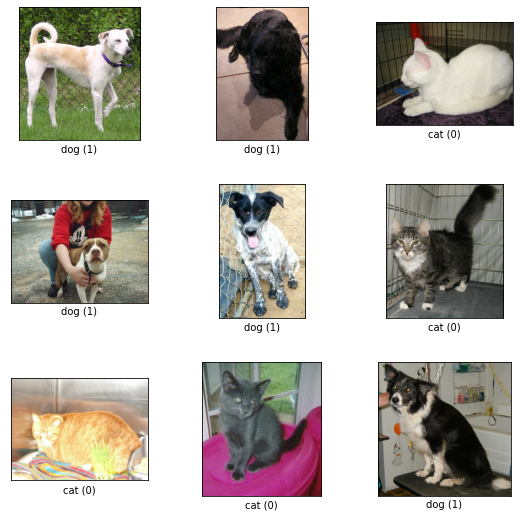

In [15]:
fig = tfds.show_examples(ds_train, ds_info)

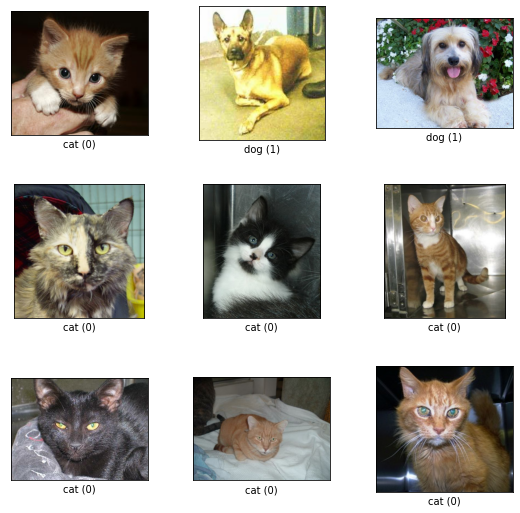

In [16]:
fig = tfds.show_examples(ds_test, ds_info)

In [17]:
#정규화 함수
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [32, 32])   #OOM 에러로 인해 이미지 사이즈를 줄임.
    image = tf.cast(image, tf.float32) / 255 
    
    return image, label

In [18]:
#정규화 적용 함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    #ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

## 4. ResNet과 Plain 모델 성능 비교

In [19]:
BATCH_SIZE = 32
EPOCH = 10

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

## 4.1 ResNet-34 VS Plain-34

In [20]:
#ResNet-34 학습
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(18610/BATCH_SIZE),
    validation_steps=int(2326/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/10


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 27/581 [>.............................] - ETA: 20s - loss: 2.4703 - accuracy: 0.3831

 39/581 [=>............................] - ETA: 20s - loss: 2.0573 - accuracy: 0.4103

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


113/581 [====>.........................] - ETA: 17s - loss: 1.2281 - accuracy: 0.4795

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


319/581 [===============>..............] - ETA: 9s - loss: 1.1918 - accuracy: 0.5067

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


331/581 [================>.............] - ETA: 9s - loss: 1.2073 - accuracy: 0.5069

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 8s - loss: 1.2126 - accuracy: 0.5075

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


371/581 [==================>...........] - ETA: 7s - loss: 1.2192 - accuracy: 0.5084

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 7s - loss: 1.2203 - accuracy: 0.5096

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/581 [============================>.] - ETA: 0s - loss: 1.3294 - accuracy: 0.5194

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


581/581 [==============================] - 78s 47ms/step - loss: 1.3298 - accuracy: 0.5195 - val_loss: 1.0371 - val_accuracy: 0.5694
Epoch 2/10
 33/581 [>.............................] - ETA: 20s - loss: 1.8174 - accuracy: 0.5341

 43/581 [=>............................] - ETA: 19s - loss: 1.7830 - accuracy: 0.5400

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


117/581 [=====>........................] - ETA: 17s - loss: 1.7339 - accuracy: 0.5622

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


325/581 [===============>..............] - ETA: 9s - loss: 1.8577 - accuracy: 0.5758

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


335/581 [================>.............] - ETA: 9s - loss: 1.8762 - accuracy: 0.5771

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


349/581 [=================>............] - ETA: 8s - loss: 1.8917 - accuracy: 0.5784

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 7s - loss: 1.9192 - accuracy: 0.5819

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 7s - loss: 1.9208 - accuracy: 0.5835

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.2116 - accuracy: 0.5845

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


581/581 [==============================] - 25s 44ms/step - loss: 2.2116 - accuracy: 0.5845 - val_loss: 2.3962 - val_accuracy: 0.5829
Epoch 3/10
 35/581 [>.............................] - ETA: 20s - loss: 2.6763 - accuracy: 0.5661

 47/581 [=>............................] - ETA: 19s - loss: 2.7482 - accuracy: 0.5539

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


119/581 [=====>........................] - ETA: 16s - loss: 2.7726 - accuracy: 0.5376

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


325/581 [===============>..............] - ETA: 9s - loss: 2.5991 - accuracy: 0.5183

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


339/581 [================>.............] - ETA: 8s - loss: 2.5903 - accuracy: 0.5181

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


351/581 [=================>............] - ETA: 8s - loss: 2.5783 - accuracy: 0.5185

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 7s - loss: 2.5619 - accuracy: 0.5182

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 7s - loss: 2.5588 - accuracy: 0.5174

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/581 [============================>.] - ETA: 0s - loss: 2.4973 - accuracy: 0.5150

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


581/581 [==============================] - 26s 44ms/step - loss: 2.4969 - accuracy: 0.5151 - val_loss: 2.2996 - val_accuracy: 0.4887
Epoch 4/10
  5/581 [..............................] - ETA: 22s - loss: 2.3026 - accuracy: 0.5125

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 35/581 [>.............................] - ETA: 20s - loss: 2.3195 - accuracy: 0.5045

 45/581 [=>............................] - ETA: 20s - loss: 2.3157 - accuracy: 0.5069

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


121/581 [=====>........................] - ETA: 16s - loss: 2.3057 - accuracy: 0.5130

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


325/581 [===============>..............] - ETA: 9s - loss: 2.3045 - accuracy: 0.5030

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


337/581 [================>.............] - ETA: 8s - loss: 2.3044 - accuracy: 0.5044

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


351/581 [=================>............] - ETA: 8s - loss: 2.3037 - accuracy: 0.5053

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 7s - loss: 2.3044 - accuracy: 0.5035

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 7s - loss: 2.3042 - accuracy: 0.5038

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.3056 - accuracy: 0.5048

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


581/581 [==============================] - 25s 44ms/step - loss: 2.3056 - accuracy: 0.5048 - val_loss: 2.2996 - val_accuracy: 0.5048
Epoch 5/10
  5/581 [..............................] - ETA: 20s - loss: 2.3026 - accuracy: 0.5125

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 35/581 [>.............................] - ETA: 19s - loss: 2.3144 - accuracy: 0.5125

 47/581 [=>............................] - ETA: 19s - loss: 2.3114 - accuracy: 0.5160

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


123/581 [=====>........................] - ETA: 16s - loss: 2.3054 - accuracy: 0.5124

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


327/581 [===============>..............] - ETA: 9s - loss: 2.3055 - accuracy: 0.5054

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


339/581 [================>.............] - ETA: 8s - loss: 2.3054 - accuracy: 0.5049

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


353/581 [=================>............] - ETA: 8s - loss: 2.3050 - accuracy: 0.5042

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 7s - loss: 2.3049 - accuracy: 0.5046

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


385/581 [==================>...........] - ETA: 7s - loss: 2.3048 - accuracy: 0.5054

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/581 [============================>.] - ETA: 0s - loss: 2.3048 - accuracy: 0.5048

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


581/581 [==============================] - 25s 44ms/step - loss: 2.3048 - accuracy: 0.5049 - val_loss: 2.3152 - val_accuracy: 0.4714
Epoch 6/10
  5/581 [..............................] - ETA: 20s - loss: 2.3026 - accuracy: 0.4750

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 35/581 [>.............................] - ETA: 19s - loss: 2.3026 - accuracy: 0.4955

 47/581 [=>............................] - ETA: 19s - loss: 2.3026 - accuracy: 0.5027

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


123/581 [=====>........................] - ETA: 16s - loss: 2.3026 - accuracy: 0.5079

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


330/581 [================>.............] - ETA: 9s - loss: 2.3024 - accuracy: 0.5025

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


340/581 [================>.............] - ETA: 8s - loss: 2.3024 - accuracy: 0.5026

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


354/581 [=================>............] - ETA: 8s - loss: 2.3024 - accuracy: 0.5031

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 7s - loss: 2.3024 - accuracy: 0.5042

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


386/581 [==================>...........] - ETA: 7s - loss: 2.3024 - accuracy: 0.5045

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.3022 - accuracy: 0.5038

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


581/581 [==============================] - 25s 44ms/step - loss: 2.3022 - accuracy: 0.5038 - val_loss: 2.3054 - val_accuracy: 0.5169
Epoch 7/10
  7/581 [..............................] - ETA: 20s - loss: 2.3026 - accuracy: 0.5089

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 39/581 [=>............................] - ETA: 20s - loss: 2.3026 - accuracy: 0.5088

 49/581 [=>............................] - ETA: 19s - loss: 2.3026 - accuracy: 0.5019

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


125/581 [=====>........................] - ETA: 16s - loss: 2.3050 - accuracy: 0.5077

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


331/581 [================>.............] - ETA: 9s - loss: 2.3033 - accuracy: 0.5043

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


341/581 [================>.............] - ETA: 8s - loss: 2.3033 - accuracy: 0.5046

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


353/581 [=================>............] - ETA: 8s - loss: 2.3032 - accuracy: 0.5050

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 7s - loss: 2.3032 - accuracy: 0.5068

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


385/581 [==================>...........] - ETA: 7s - loss: 2.3032 - accuracy: 0.5063

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/581 [============================>.] - ETA: 0s - loss: 2.3037 - accuracy: 0.5040

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


581/581 [==============================] - 25s 44ms/step - loss: 2.3037 - accuracy: 0.5037 - val_loss: 2.3044 - val_accuracy: 0.4952
Epoch 8/10
  7/581 [..............................] - ETA: 20s - loss: 2.3026 - accuracy: 0.4777

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 41/581 [=>............................] - ETA: 19s - loss: 2.3026 - accuracy: 0.4863

 51/581 [=>............................] - ETA: 19s - loss: 2.3026 - accuracy: 0.4926

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


122/581 [=====>........................] - ETA: 16s - loss: 2.3026 - accuracy: 0.4962

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


330/581 [================>.............] - ETA: 9s - loss: 2.3044 - accuracy: 0.4983

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


344/581 [================>.............] - ETA: 8s - loss: 2.3043 - accuracy: 0.4966

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


354/581 [=================>............] - ETA: 8s - loss: 2.3043 - accuracy: 0.4970

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 7s - loss: 2.3042 - accuracy: 0.4976

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


388/581 [===================>..........] - ETA: 7s - loss: 2.3041 - accuracy: 0.4964

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.3036 - accuracy: 0.5028

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


581/581 [==============================] - 25s 44ms/step - loss: 2.3036 - accuracy: 0.5028 - val_loss: 2.3093 - val_accuracy: 0.4939
Epoch 9/10
  7/581 [..............................] - ETA: 20s - loss: 2.2923 - accuracy: 0.5312

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 39/581 [=>............................] - ETA: 19s - loss: 2.3007 - accuracy: 0.4992

 53/581 [=>............................] - ETA: 19s - loss: 2.3012 - accuracy: 0.5000

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


125/581 [=====>........................] - ETA: 16s - loss: 2.3020 - accuracy: 0.5135

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


331/581 [================>.............] - ETA: 9s - loss: 2.3019 - accuracy: 0.5062

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 8s - loss: 2.3020 - accuracy: 0.5064

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


355/581 [=================>............] - ETA: 8s - loss: 2.3020 - accuracy: 0.5060

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 7s - loss: 2.3020 - accuracy: 0.5070

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


389/581 [===================>..........] - ETA: 7s - loss: 2.3020 - accuracy: 0.5067

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.3029 - accuracy: 0.5056

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


581/581 [==============================] - 25s 44ms/step - loss: 2.3029 - accuracy: 0.5056 - val_loss: 2.3074 - val_accuracy: 0.4826
Epoch 10/10
  9/581 [..............................] - ETA: 20s - loss: 2.3026 - accuracy: 0.4861

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 39/581 [=>............................] - ETA: 19s - loss: 2.3026 - accuracy: 0.5112

 51/581 [=>............................] - ETA: 19s - loss: 2.3026 - accuracy: 0.5165

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


127/581 [=====>........................] - ETA: 16s - loss: 2.3026 - accuracy: 0.5042

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 9s - loss: 2.3022 - accuracy: 0.5053

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 8s - loss: 2.3022 - accuracy: 0.5040

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


357/581 [=================>............] - ETA: 8s - loss: 2.3022 - accuracy: 0.5056

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


385/581 [==================>...........] - ETA: 7s - loss: 2.3022 - accuracy: 0.5050

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


389/581 [===================>..........] - ETA: 7s - loss: 2.3022 - accuracy: 0.5048

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.3024 - accuracy: 0.5022

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


581/581 [==============================] - 25s 44ms/step - loss: 2.3024 - accuracy: 0.5022 - val_loss: 2.2996 - val_accuracy: 0.4970


In [21]:
#Plain-34 학습
plainnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plainnet_34 = plainnet_34.fit(
    ds_train,
    steps_per_epoch=int(18610/BATCH_SIZE),
    validation_steps=int(2326/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
  3/581 [..............................] - ETA: 30s - loss: 10.4336 - accuracy: 0.0625  

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 30/581 [>.............................] - ETA: 21s - loss: 5.9007 - accuracy: 0.2115

 44/581 [=>............................] - ETA: 20s - loss: 4.5863 - accuracy: 0.2777

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


118/581 [=====>........................] - ETA: 17s - loss: 2.2721 - accuracy: 0.4110

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


322/581 [===============>..............] - ETA: 9s - loss: 1.2905 - accuracy: 0.4746

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 9s - loss: 1.2658 - accuracy: 0.4754

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


348/581 [================>.............] - ETA: 8s - loss: 1.2459 - accuracy: 0.4769

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


374/581 [==================>...........] - ETA: 7s - loss: 1.2127 - accuracy: 0.4811

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 7s - loss: 1.2018 - accuracy: 0.4821

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/581 [============================>.] - ETA: 0s - loss: 1.0824 - accuracy: 0.5016

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


581/581 [==============================] - 33s 45ms/step - loss: 1.0825 - accuracy: 0.5013 - val_loss: 0.9325 - val_accuracy: 0.5477
Epoch 2/10
 35/581 [>.............................] - ETA: 19s - loss: 1.1819 - accuracy: 0.5339

 43/581 [=>............................] - ETA: 19s - loss: 1.2059 - accuracy: 0.5356

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


117/581 [=====>........................] - ETA: 16s - loss: 1.5733 - accuracy: 0.5542

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


325/581 [===============>..............] - ETA: 9s - loss: 1.7869 - accuracy: 0.5630

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


337/581 [================>.............] - ETA: 8s - loss: 1.7862 - accuracy: 0.5633

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


347/581 [================>.............] - ETA: 8s - loss: 1.7924 - accuracy: 0.5641

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 7s - loss: 1.8060 - accuracy: 0.5652

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 7s - loss: 1.8046 - accuracy: 0.5650

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.8441 - accuracy: 0.5616

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


581/581 [==============================] - 25s 44ms/step - loss: 1.8441 - accuracy: 0.5616 - val_loss: 1.7855 - val_accuracy: 0.5516
Epoch 3/10
  3/581 [..............................] - ETA: 23s - loss: 2.1268 - accuracy: 0.5312

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 33/581 [>.............................] - ETA: 20s - loss: 2.2616 - accuracy: 0.5246

 45/581 [=>............................] - ETA: 19s - loss: 2.2799 - accuracy: 0.5299

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


119/581 [=====>........................] - ETA: 16s - loss: 2.2917 - accuracy: 0.5144

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


327/581 [===============>..............] - ETA: 9s - loss: 2.2629 - accuracy: 0.5067

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


337/581 [================>.............] - ETA: 8s - loss: 2.2588 - accuracy: 0.5071

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


349/581 [=================>............] - ETA: 8s - loss: 2.2573 - accuracy: 0.5065

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 7s - loss: 2.2541 - accuracy: 0.5073

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 7s - loss: 2.2535 - accuracy: 0.5082

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/581 [============================>.] - ETA: 0s - loss: 2.2488 - accuracy: 0.5066

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


581/581 [==============================] - 25s 43ms/step - loss: 2.2488 - accuracy: 0.5067 - val_loss: 2.3690 - val_accuracy: 0.4991
Epoch 4/10
  5/581 [..............................] - ETA: 20s - loss: 2.1833 - accuracy: 0.4875

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 35/581 [>.............................] - ETA: 20s - loss: 2.2851 - accuracy: 0.4875

 45/581 [=>............................] - ETA: 19s - loss: 2.3035 - accuracy: 0.4958

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


121/581 [=====>........................] - ETA: 16s - loss: 2.3117 - accuracy: 0.4997

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


327/581 [===============>..............] - ETA: 9s - loss: 2.3507 - accuracy: 0.5037

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


337/581 [================>.............] - ETA: 8s - loss: 2.3516 - accuracy: 0.5039

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


349/581 [=================>............] - ETA: 8s - loss: 2.3518 - accuracy: 0.5037

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 7s - loss: 2.3571 - accuracy: 0.5039

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 7s - loss: 2.3563 - accuracy: 0.5038

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.3380 - accuracy: 0.5060

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


581/581 [==============================] - 25s 44ms/step - loss: 2.3380 - accuracy: 0.5060 - val_loss: 2.3183 - val_accuracy: 0.4895
Epoch 5/10
  5/581 [..............................] - ETA: 21s - loss: 2.3026 - accuracy: 0.4875

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 35/581 [>.............................] - ETA: 20s - loss: 2.3112 - accuracy: 0.4848

 49/581 [=>............................] - ETA: 19s - loss: 2.3087 - accuracy: 0.4815

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


121/581 [=====>........................] - ETA: 16s - loss: 2.3045 - accuracy: 0.4904

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


327/581 [===============>..............] - ETA: 9s - loss: 2.3043 - accuracy: 0.5021

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


341/581 [================>.............] - ETA: 8s - loss: 2.3042 - accuracy: 0.5026

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


351/581 [=================>............] - ETA: 8s - loss: 2.3042 - accuracy: 0.5036

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 7s - loss: 2.3041 - accuracy: 0.5028

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 7s - loss: 2.3050 - accuracy: 0.5029

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/581 [============================>.] - ETA: 0s - loss: 2.3054 - accuracy: 0.5024

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


581/581 [==============================] - 25s 44ms/step - loss: 2.3054 - accuracy: 0.5024 - val_loss: 2.3302 - val_accuracy: 0.4764
Epoch 6/10
  7/581 [..............................] - ETA: 21s - loss: 2.3026 - accuracy: 0.5045

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 39/581 [=>............................] - ETA: 20s - loss: 2.3026 - accuracy: 0.5016

 47/581 [=>............................] - ETA: 19s - loss: 2.3026 - accuracy: 0.5080

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


123/581 [=====>........................] - ETA: 16s - loss: 2.3014 - accuracy: 0.5008

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


327/581 [===============>..............] - ETA: 9s - loss: 2.3035 - accuracy: 0.5048

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


341/581 [================>.............] - ETA: 8s - loss: 2.3034 - accuracy: 0.5038

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


351/581 [=================>............] - ETA: 8s - loss: 2.3034 - accuracy: 0.5030

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 7s - loss: 2.3042 - accuracy: 0.5005

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


385/581 [==================>...........] - ETA: 7s - loss: 2.3042 - accuracy: 0.5004

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.3044 - accuracy: 0.5060

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


581/581 [==============================] - 25s 43ms/step - loss: 2.3044 - accuracy: 0.5060 - val_loss: 2.3299 - val_accuracy: 0.5017
Epoch 7/10
  5/581 [..............................] - ETA: 20s - loss: 2.3026 - accuracy: 0.5063

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 37/581 [>.............................] - ETA: 19s - loss: 2.3026 - accuracy: 0.4924

 49/581 [=>............................] - ETA: 19s - loss: 2.3026 - accuracy: 0.4911

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


123/581 [=====>........................] - ETA: 16s - loss: 2.3026 - accuracy: 0.4982

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


331/581 [================>.............] - ETA: 9s - loss: 2.3024 - accuracy: 0.5011

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


341/581 [================>.............] - ETA: 8s - loss: 2.3024 - accuracy: 0.5005

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


353/581 [=================>............] - ETA: 8s - loss: 2.3024 - accuracy: 0.5016

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 7s - loss: 2.3024 - accuracy: 0.5033

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


385/581 [==================>...........] - ETA: 7s - loss: 2.3024 - accuracy: 0.5031

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.3031 - accuracy: 0.5032

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


581/581 [==============================] - 25s 43ms/step - loss: 2.3031 - accuracy: 0.5032 - val_loss: 2.3127 - val_accuracy: 0.4913
Epoch 8/10
  9/581 [..............................] - ETA: 21s - loss: 2.2946 - accuracy: 0.5139

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 39/581 [=>............................] - ETA: 19s - loss: 2.3007 - accuracy: 0.5008

 49/581 [=>............................] - ETA: 19s - loss: 2.3011 - accuracy: 0.5000

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


123/581 [=====>........................] - ETA: 16s - loss: 2.3050 - accuracy: 0.5013

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


329/581 [===============>..............] - ETA: 9s - loss: 2.3047 - accuracy: 0.5028

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


343/581 [================>.............] - ETA: 8s - loss: 2.3046 - accuracy: 0.5019

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


355/581 [=================>............] - ETA: 8s - loss: 2.3046 - accuracy: 0.5025

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 7s - loss: 2.3054 - accuracy: 0.5038

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


389/581 [===================>..........] - ETA: 6s - loss: 2.3054 - accuracy: 0.5043

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.3045 - accuracy: 0.5055

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


581/581 [==============================] - 25s 43ms/step - loss: 2.3045 - accuracy: 0.5055 - val_loss: 2.3026 - val_accuracy: 0.4912
Epoch 9/10
 11/581 [..............................] - ETA: 20s - loss: 2.3026 - accuracy: 0.4716

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 39/581 [=>............................] - ETA: 19s - loss: 2.3026 - accuracy: 0.4848

 49/581 [=>............................] - ETA: 19s - loss: 2.3026 - accuracy: 0.4898

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


125/581 [=====>........................] - ETA: 16s - loss: 2.3026 - accuracy: 0.4920

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


331/581 [================>.............] - ETA: 9s - loss: 2.3026 - accuracy: 0.4988

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


343/581 [================>.............] - ETA: 8s - loss: 2.3026 - accuracy: 0.5003

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


355/581 [=================>............] - ETA: 8s - loss: 2.3026 - accuracy: 0.5011

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 7s - loss: 2.3026 - accuracy: 0.5007

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


389/581 [===================>..........] - ETA: 7s - loss: 2.3026 - accuracy: 0.4996

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/581 [============================>.] - ETA: 0s - loss: 2.3033 - accuracy: 0.5008

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


581/581 [==============================] - 25s 44ms/step - loss: 2.3033 - accuracy: 0.5009 - val_loss: 2.3062 - val_accuracy: 0.4952
Epoch 10/10
  9/581 [..............................] - ETA: 20s - loss: 2.3026 - accuracy: 0.5451

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 43/581 [=>............................] - ETA: 19s - loss: 2.3026 - accuracy: 0.4971

 53/581 [=>............................] - ETA: 19s - loss: 2.3026 - accuracy: 0.5029

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


125/581 [=====>........................] - ETA: 16s - loss: 2.3026 - accuracy: 0.5008

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 9s - loss: 2.3038 - accuracy: 0.5007

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 8s - loss: 2.3038 - accuracy: 0.5004

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


355/581 [=================>............] - ETA: 8s - loss: 2.3037 - accuracy: 0.5008

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 7s - loss: 2.3037 - accuracy: 0.5028

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


389/581 [===================>..........] - ETA: 7s - loss: 2.3036 - accuracy: 0.5031

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.3032 - accuracy: 0.5041

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


581/581 [==============================] - 25s 44ms/step - loss: 2.3032 - accuracy: 0.5041 - val_loss: 2.2992 - val_accuracy: 0.4887


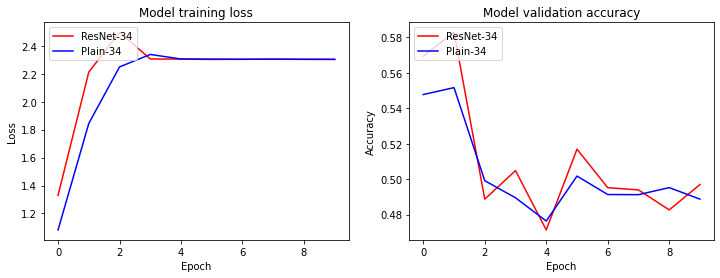

In [22]:
#ResNet-34 VS Plain-34 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_plainnet_34.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'Plain-34'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_plainnet_34.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'Plain-34'], loc='upper left')

plt.show()

## 4.1 ResNet-50 VS Plain-50

In [23]:
#ResNet-50 학습
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(18610/BATCH_SIZE),
    validation_steps=int(2326/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 29/581 [>.............................] - ETA: 45s - loss: 3.1467 - accuracy: 0.3879

 42/581 [=>............................] - ETA: 44s - loss: 2.4808 - accuracy: 0.4286

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 38s - loss: 1.3803 - accuracy: 0.4815

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


321/581 [===============>..............] - ETA: 21s - loss: 0.9527 - accuracy: 0.4863

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


334/581 [================>.............] - ETA: 20s - loss: 0.9426 - accuracy: 0.4867

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


346/581 [================>.............] - ETA: 19s - loss: 0.9340 - accuracy: 0.4869

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


373/581 [==================>...........] - ETA: 17s - loss: 0.9166 - accuracy: 0.4888

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 16s - loss: 0.9131 - accuracy: 0.4892

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


579/581 [============================>.] - ETA: 0s - loss: 0.8397 - accuracy: 0.4928

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.8392 - accuracy: 0.4928

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


581/581 [==============================] - 64s 91ms/step - loss: 0.8392 - accuracy: 0.4928 - val_loss: 0.6926 - val_accuracy: 0.4978
Epoch 2/10
 31/581 [>.............................] - ETA: 44s - loss: 0.6923 - accuracy: 0.5010

 40/581 [=>............................] - ETA: 44s - loss: 0.7040 - accuracy: 0.5016

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/581 [====>.........................] - ETA: 41s - loss: 0.7061 - accuracy: 0.5046

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


323/581 [===============>..............] - ETA: 21s - loss: 0.6979 - accuracy: 0.5019

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


335/581 [================>.............] - ETA: 20s - loss: 0.6978 - accuracy: 0.5015

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


346/581 [================>.............] - ETA: 19s - loss: 0.6976 - accuracy: 0.5001

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


373/581 [==================>...........] - ETA: 17s - loss: 0.6973 - accuracy: 0.5022

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 16s - loss: 0.6973 - accuracy: 0.5017

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6959 - accuracy: 0.5032

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


581/581 [==============================] - 53s 91ms/step - loss: 0.6959 - accuracy: 0.5032 - val_loss: 0.6931 - val_accuracy: 0.5022
Epoch 3/10
 31/581 [>.............................] - ETA: 44s - loss: 0.6932 - accuracy: 0.4960

 44/581 [=>............................] - ETA: 43s - loss: 0.6932 - accuracy: 0.5050

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 37s - loss: 0.6930 - accuracy: 0.5038

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


322/581 [===============>..............] - ETA: 21s - loss: 0.6931 - accuracy: 0.4980

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 19s - loss: 0.6931 - accuracy: 0.4985

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


347/581 [================>.............] - ETA: 19s - loss: 0.6931 - accuracy: 0.4987

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


374/581 [==================>...........] - ETA: 16s - loss: 0.6931 - accuracy: 0.4978

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 16s - loss: 0.6931 - accuracy: 0.4975

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.4995

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


581/581 [==============================] - 52s 89ms/step - loss: 0.6931 - accuracy: 0.4995 - val_loss: 0.6931 - val_accuracy: 0.4926
Epoch 4/10
 31/581 [>.............................] - ETA: 44s - loss: 0.6931 - accuracy: 0.5050

 42/581 [=>............................] - ETA: 43s - loss: 0.6931 - accuracy: 0.5052

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


118/581 [=====>........................] - ETA: 37s - loss: 0.6932 - accuracy: 0.5140

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


324/581 [===============>..............] - ETA: 20s - loss: 0.6932 - accuracy: 0.5083

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


335/581 [================>.............] - ETA: 20s - loss: 0.6932 - accuracy: 0.5085

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


349/581 [=================>............] - ETA: 18s - loss: 0.6932 - accuracy: 0.5076

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 16s - loss: 0.6932 - accuracy: 0.5066

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 16s - loss: 0.6932 - accuracy: 0.5064

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5060

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


581/581 [==============================] - 52s 89ms/step - loss: 0.6932 - accuracy: 0.5060 - val_loss: 0.6931 - val_accuracy: 0.5091
Epoch 5/10
  3/581 [..............................] - ETA: 46s - loss: 0.6931 - accuracy: 0.5000

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 33/581 [>.............................] - ETA: 44s - loss: 0.6933 - accuracy: 0.5265

 43/581 [=>............................] - ETA: 43s - loss: 0.6933 - accuracy: 0.5262

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


118/581 [=====>........................] - ETA: 37s - loss: 0.6932 - accuracy: 0.5085

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 20s - loss: 0.6931 - accuracy: 0.5115

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 19s - loss: 0.6931 - accuracy: 0.5107

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


348/581 [================>.............] - ETA: 18s - loss: 0.6931 - accuracy: 0.5090

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 16s - loss: 0.6931 - accuracy: 0.5081

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 16s - loss: 0.6931 - accuracy: 0.5074

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5075

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


581/581 [==============================] - 52s 89ms/step - loss: 0.6932 - accuracy: 0.5075 - val_loss: 0.6931 - val_accuracy: 0.4987
Epoch 6/10
  2/581 [..............................] - ETA: 46s - loss: 0.6931 - accuracy: 0.4219

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 35/581 [>.............................] - ETA: 44s - loss: 0.6932 - accuracy: 0.5170

 46/581 [=>............................] - ETA: 43s - loss: 0.6932 - accuracy: 0.5224

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


119/581 [=====>........................] - ETA: 37s - loss: 0.6932 - accuracy: 0.5234

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 20s - loss: 0.6932 - accuracy: 0.5100

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


339/581 [================>.............] - ETA: 19s - loss: 0.6932 - accuracy: 0.5106

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


351/581 [=================>............] - ETA: 18s - loss: 0.6932 - accuracy: 0.5094

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 16s - loss: 0.6932 - accuracy: 0.5083

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


385/581 [==================>...........] - ETA: 15s - loss: 0.6932 - accuracy: 0.5088

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5088

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


581/581 [==============================] - 52s 89ms/step - loss: 0.6932 - accuracy: 0.5088 - val_loss: 0.6932 - val_accuracy: 0.5074
Epoch 7/10
  6/581 [..............................] - ETA: 47s - loss: 0.6931 - accuracy: 0.4844

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 35/581 [>.............................] - ETA: 44s - loss: 0.6931 - accuracy: 0.4982

 47/581 [=>............................] - ETA: 43s - loss: 0.6931 - accuracy: 0.5126

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


119/581 [=====>........................] - ETA: 37s - loss: 0.6931 - accuracy: 0.5102

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


328/581 [===============>..............] - ETA: 20s - loss: 0.6932 - accuracy: 0.5052

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


339/581 [================>.............] - ETA: 19s - loss: 0.6932 - accuracy: 0.5053

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


351/581 [=================>............] - ETA: 18s - loss: 0.6932 - accuracy: 0.5050

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 16s - loss: 0.6932 - accuracy: 0.5044

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


384/581 [==================>...........] - ETA: 16s - loss: 0.6932 - accuracy: 0.5050

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7004 - accuracy: 0.5070

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


581/581 [==============================] - 52s 89ms/step - loss: 0.7004 - accuracy: 0.5070 - val_loss: 0.6931 - val_accuracy: 0.5206
Epoch 8/10
  6/581 [..............................] - ETA: 47s - loss: 0.6931 - accuracy: 0.5052

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 35/581 [>.............................] - ETA: 44s - loss: 0.6931 - accuracy: 0.5027

 49/581 [=>............................] - ETA: 43s - loss: 0.6931 - accuracy: 0.4968

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


120/581 [=====>........................] - ETA: 37s - loss: 0.6931 - accuracy: 0.5052

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


328/581 [===============>..............] - ETA: 20s - loss: 0.6931 - accuracy: 0.5027

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


341/581 [================>.............] - ETA: 19s - loss: 0.6931 - accuracy: 0.5023

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


351/581 [=================>............] - ETA: 18s - loss: 0.6931 - accuracy: 0.5046

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 16s - loss: 0.6931 - accuracy: 0.5050

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


385/581 [==================>...........] - ETA: 15s - loss: 0.6931 - accuracy: 0.5044

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7446 - accuracy: 0.5047

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


581/581 [==============================] - 52s 89ms/step - loss: 0.7446 - accuracy: 0.5047 - val_loss: 1.3142 - val_accuracy: 0.5091
Epoch 9/10
  7/581 [..............................] - ETA: 47s - loss: 1.1547 - accuracy: 0.5089

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 37/581 [>.............................] - ETA: 44s - loss: 1.0599 - accuracy: 0.5127

 50/581 [=>............................] - ETA: 43s - loss: 1.0371 - accuracy: 0.5169

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


121/581 [=====>........................] - ETA: 37s - loss: 1.1546 - accuracy: 0.5132

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


329/581 [===============>..............] - ETA: 20s - loss: 1.3061 - accuracy: 0.5085

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


343/581 [================>.............] - ETA: 19s - loss: 1.3316 - accuracy: 0.5086

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


353/581 [=================>............] - ETA: 18s - loss: 1.3523 - accuracy: 0.5084

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 16s - loss: 1.3748 - accuracy: 0.5099

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


387/581 [==================>...........] - ETA: 15s - loss: 1.3758 - accuracy: 0.5095

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.4638 - accuracy: 0.5129

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


581/581 [==============================] - 52s 90ms/step - loss: 1.4638 - accuracy: 0.5129 - val_loss: 1.1441 - val_accuracy: 0.5208
Epoch 10/10
  8/581 [..............................] - ETA: 47s - loss: 1.3583 - accuracy: 0.5195

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 37/581 [>.............................] - ETA: 44s - loss: 1.6456 - accuracy: 0.4992

 48/581 [=>............................] - ETA: 43s - loss: 1.5628 - accuracy: 0.5078

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


123/581 [=====>........................] - ETA: 37s - loss: 1.4512 - accuracy: 0.5224

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


330/581 [================>.............] - ETA: 20s - loss: 1.4582 - accuracy: 0.5259

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


341/581 [================>.............] - ETA: 19s - loss: 1.4469 - accuracy: 0.5269

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


353/581 [=================>............] - ETA: 18s - loss: 1.4493 - accuracy: 0.5271

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 16s - loss: 1.4351 - accuracy: 0.5283

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


387/581 [==================>...........] - ETA: 15s - loss: 1.4330 - accuracy: 0.5289

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.3950 - accuracy: 0.5312

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


581/581 [==============================] - 52s 90ms/step - loss: 1.3950 - accuracy: 0.5312 - val_loss: 1.2774 - val_accuracy: 0.5460


In [24]:
#Plain-50 학습
plainnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plainnet_50 = plainnet_50.fit(
    ds_train,
    steps_per_epoch=int(18610/BATCH_SIZE),
    validation_steps=int(2326/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
  1/581 [..............................] - ETA: 1:35:05 - loss: 7.1890 - accuracy: 0.1875

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 29/581 [>.............................] - ETA: 46s - loss: 2.0117 - accuracy: 0.3869

 39/581 [=>............................] - ETA: 45s - loss: 1.7223 - accuracy: 0.4207

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


114/581 [====>.........................] - ETA: 38s - loss: 1.0675 - accuracy: 0.4745

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


319/581 [===============>..............] - ETA: 21s - loss: 1.3326 - accuracy: 0.5006

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 20s - loss: 1.3490 - accuracy: 0.5024

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 19s - loss: 1.3591 - accuracy: 0.5024

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 17s - loss: 1.3828 - accuracy: 0.5058

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 16s - loss: 1.3907 - accuracy: 0.5060

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/581 [============================>.] - ETA: 0s - loss: 1.5719 - accuracy: 0.5086

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.5736 - accuracy: 0.5086

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


581/581 [==============================] - 63s 92ms/step - loss: 1.5736 - accuracy: 0.5086 - val_loss: 2.2061 - val_accuracy: 0.5200
Epoch 2/10
 32/581 [>.............................] - ETA: 44s - loss: 2.6987 - accuracy: 0.4824

 40/581 [=>............................] - ETA: 44s - loss: 2.5850 - accuracy: 0.4875

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/581 [====>.........................] - ETA: 38s - loss: 2.2543 - accuracy: 0.5127

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


321/581 [===============>..............] - ETA: 21s - loss: 1.7005 - accuracy: 0.5127

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 20s - loss: 1.6644 - accuracy: 0.5127

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


346/581 [================>.............] - ETA: 19s - loss: 1.6291 - accuracy: 0.5123

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


373/581 [==================>...........] - ETA: 17s - loss: 1.5612 - accuracy: 0.5134

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 16s - loss: 1.5487 - accuracy: 0.5125

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/581 [============================>.] - ETA: 0s - loss: 1.4451 - accuracy: 0.5142

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.4462 - accuracy: 0.5143

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


581/581 [==============================] - 52s 90ms/step - loss: 1.4462 - accuracy: 0.5143 - val_loss: 1.6081 - val_accuracy: 0.5254
Epoch 3/10
 32/581 [>.............................] - ETA: 45s - loss: 1.4107 - accuracy: 0.5439

 42/581 [=>............................] - ETA: 44s - loss: 1.3297 - accuracy: 0.5335

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 38s - loss: 1.0115 - accuracy: 0.5207

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


323/581 [===============>..............] - ETA: 21s - loss: 0.8249 - accuracy: 0.5148

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


335/581 [================>.............] - ETA: 20s - loss: 0.8214 - accuracy: 0.5135

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


348/581 [================>.............] - ETA: 19s - loss: 0.8179 - accuracy: 0.5138

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 16s - loss: 0.8091 - accuracy: 0.5127

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 16s - loss: 0.8073 - accuracy: 0.5137

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7768 - accuracy: 0.5123

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


581/581 [==============================] - 52s 90ms/step - loss: 0.7768 - accuracy: 0.5123 - val_loss: 0.8774 - val_accuracy: 0.5070
Epoch 4/10
 34/581 [>.............................] - ETA: 44s - loss: 0.7077 - accuracy: 0.5386

 42/581 [=>............................] - ETA: 43s - loss: 0.7164 - accuracy: 0.5379

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


117/581 [=====>........................] - ETA: 37s - loss: 0.7164 - accuracy: 0.5134

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


325/581 [===============>..............] - ETA: 20s - loss: 0.7154 - accuracy: 0.5091

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


335/581 [================>.............] - ETA: 20s - loss: 0.7147 - accuracy: 0.5092

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


348/581 [================>.............] - ETA: 18s - loss: 0.7139 - accuracy: 0.5083

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 16s - loss: 0.7124 - accuracy: 0.5081

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 16s - loss: 0.7121 - accuracy: 0.5078

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7065 - accuracy: 0.5075

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


581/581 [==============================] - 52s 90ms/step - loss: 0.7065 - accuracy: 0.5075 - val_loss: 0.6995 - val_accuracy: 0.5200
Epoch 5/10
  2/581 [..............................] - ETA: 44s - loss: 0.6931 - accuracy: 0.5600

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 34/581 [>.............................] - ETA: 44s - loss: 0.7062 - accuracy: 0.5382

 44/581 [=>............................] - ETA: 43s - loss: 0.7032 - accuracy: 0.5287

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


117/581 [=====>........................] - ETA: 37s - loss: 0.7131 - accuracy: 0.5182

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


324/581 [===============>..............] - ETA: 20s - loss: 0.7231 - accuracy: 0.5195

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


337/581 [================>.............] - ETA: 19s - loss: 0.7286 - accuracy: 0.5198

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


350/581 [=================>............] - ETA: 18s - loss: 0.7352 - accuracy: 0.5206

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 16s - loss: 0.7368 - accuracy: 0.5204

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 16s - loss: 0.7372 - accuracy: 0.5201

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7495 - accuracy: 0.5208

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


581/581 [==============================] - 52s 89ms/step - loss: 0.7495 - accuracy: 0.5208 - val_loss: 0.7127 - val_accuracy: 0.5306
Epoch 6/10
  2/581 [..............................] - ETA: 47s - loss: 0.6823 - accuracy: 0.5000

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 35/581 [>.............................] - ETA: 44s - loss: 0.7301 - accuracy: 0.5196

 45/581 [=>............................] - ETA: 43s - loss: 0.7618 - accuracy: 0.5097

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


120/581 [=====>........................] - ETA: 37s - loss: 0.8515 - accuracy: 0.5174

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


327/581 [===============>..............] - ETA: 20s - loss: 1.1176 - accuracy: 0.5224

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


338/581 [================>.............] - ETA: 19s - loss: 1.1177 - accuracy: 0.5233

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


351/581 [=================>............] - ETA: 18s - loss: 1.1297 - accuracy: 0.5228

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 16s - loss: 1.1223 - accuracy: 0.5236

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


384/581 [==================>...........] - ETA: 16s - loss: 1.1188 - accuracy: 0.5238

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.1513 - accuracy: 0.5217

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


581/581 [==============================] - 52s 89ms/step - loss: 1.1513 - accuracy: 0.5217 - val_loss: 1.4945 - val_accuracy: 0.5365
Epoch 7/10
  5/581 [..............................] - ETA: 46s - loss: 1.8350 - accuracy: 0.4938

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 35/581 [>.............................] - ETA: 44s - loss: 1.8149 - accuracy: 0.5080

 46/581 [=>............................] - ETA: 43s - loss: 1.7336 - accuracy: 0.5190

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


121/581 [=====>........................] - ETA: 37s - loss: 1.7348 - accuracy: 0.5178

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 20s - loss: 1.8744 - accuracy: 0.5204

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


339/581 [================>.............] - ETA: 19s - loss: 1.8633 - accuracy: 0.5214

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


350/581 [=================>............] - ETA: 18s - loss: 1.8478 - accuracy: 0.5230

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 16s - loss: 1.8299 - accuracy: 0.5225

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 16s - loss: 1.8212 - accuracy: 0.5229

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.8862 - accuracy: 0.5230

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


581/581 [==============================] - 52s 90ms/step - loss: 1.8862 - accuracy: 0.5230 - val_loss: 2.1558 - val_accuracy: 0.5339
Epoch 8/10
  5/581 [..............................] - ETA: 46s - loss: 2.1348 - accuracy: 0.5750

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 35/581 [>.............................] - ETA: 44s - loss: 1.9251 - accuracy: 0.5509

 48/581 [=>............................] - ETA: 43s - loss: 1.9808 - accuracy: 0.5449

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


121/581 [=====>........................] - ETA: 37s - loss: 2.2142 - accuracy: 0.5390

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


329/581 [===============>..............] - ETA: 20s - loss: 2.4461 - accuracy: 0.5312

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


340/581 [================>.............] - ETA: 19s - loss: 2.4681 - accuracy: 0.5305

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


353/581 [=================>............] - ETA: 18s - loss: 2.4716 - accuracy: 0.5310

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 16s - loss: 2.4934 - accuracy: 0.5314

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


386/581 [==================>...........] - ETA: 15s - loss: 2.4973 - accuracy: 0.5310

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.6127 - accuracy: 0.5337

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


581/581 [==============================] - 52s 90ms/step - loss: 2.6127 - accuracy: 0.5337 - val_loss: 1.9570 - val_accuracy: 0.5521
Epoch 9/10
  6/581 [..............................] - ETA: 46s - loss: 2.4187 - accuracy: 0.5365

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 37/581 [>.............................] - ETA: 44s - loss: 2.4067 - accuracy: 0.5346

 49/581 [=>............................] - ETA: 43s - loss: 2.3919 - accuracy: 0.5338

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


121/581 [=====>........................] - ETA: 37s - loss: 2.5034 - accuracy: 0.5251

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


328/581 [===============>..............] - ETA: 20s - loss: 2.3824 - accuracy: 0.5321

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


342/581 [================>.............] - ETA: 19s - loss: 2.3954 - accuracy: 0.5302

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


353/581 [=================>............] - ETA: 18s - loss: 2.3919 - accuracy: 0.5303

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 16s - loss: 2.4098 - accuracy: 0.5306

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


387/581 [==================>...........] - ETA: 15s - loss: 2.4205 - accuracy: 0.5303

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.5456 - accuracy: 0.5347

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


581/581 [==============================] - 52s 90ms/step - loss: 2.5456 - accuracy: 0.5347 - val_loss: 2.3281 - val_accuracy: 0.5486
Epoch 10/10
  8/581 [..............................] - ETA: 46s - loss: 3.3639 - accuracy: 0.5742

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 37/581 [>.............................] - ETA: 44s - loss: 3.1739 - accuracy: 0.5355

 50/581 [=>............................] - ETA: 43s - loss: 3.0893 - accuracy: 0.5450

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


122/581 [=====>........................] - ETA: 37s - loss: 2.8625 - accuracy: 0.5428

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


330/581 [================>.............] - ETA: 20s - loss: 2.7225 - accuracy: 0.5385

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


343/581 [================>.............] - ETA: 19s - loss: 2.7523 - accuracy: 0.5374

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


355/581 [=================>............] - ETA: 18s - loss: 2.7576 - accuracy: 0.5387

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 16s - loss: 2.7842 - accuracy: 0.5393

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


389/581 [===================>..........] - ETA: 15s - loss: 2.7930 - accuracy: 0.5391

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.8044 - accuracy: 0.5437

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


581/581 [==============================] - 52s 89ms/step - loss: 2.8044 - accuracy: 0.5437 - val_loss: 2.1010 - val_accuracy: 0.5442


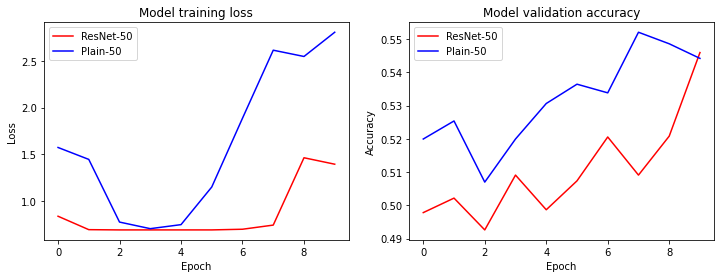

In [25]:
#ResNet-50 VS Plain-50 시각화

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_50.history['loss'], 'r')
plt.plot(history_plainnet_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-50', 'Plain-50'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_50.history['val_accuracy'], 'r')
plt.plot(history_plainnet_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-50', 'Plain-50'], loc='upper left')

plt.show()

### 회고

###### 이번 프로잭트를 진행하면서 정말 멘붕이 왔다 전에 익스도 겨우겨우 힘겹게 제출했는데 이번 GD 프로젝트 노드를 보니까 정말 손도 델수 없겠다는 느낌을 받았는데 진짜 프로잭트를 진행하는데 라이브러리를 불러오는거 제외하면 resnet구현부터 데이터셋 준비하고 정말 너무 어려워서 이번 노드는 구글링을 해서 코드를 많이 검색해서 그대로 찾아쓴게 많다 ㅠ 담에는 공부를 더 해서 코드 자체를 검색하기 보다는 아이디어 정도만 검색할수있게 공부를 해야겠다...